## Analysis of GeoLife data set
As in the previous notebook the paths are local.

In [8]:
import yaml
with open("../conf.yaml") as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)

#path to Geolife's data
geo_path = conf["data_path"] + "Geolife Trajectories 1.3/Data/"
out_path = conf["out_path"]
data_path = conf["data_path"]
geo_life_analysis_path = conf["out_path"]

We begin by loading all the dataset, adding UIDs and saving to disk after some cleaning on the data.
All the paths are local since I didn't load the dataset on uav_station's gitlab

In [24]:
%%time
import pandas as pd
import pprint as pp
import glob
import os

dirs = os.listdir(geo_path)

#this is needed because of spotlight files created by macos
from sys import platform
if (platform == "darwin"):
    dirs.remove(".DS_Store")

col_names = ["lat", "lon", "?", "alt", "days", "date", "time"]  

tid = 0
users = 0

#for each user (dir) we concat all its trajectories and append to df_all dataframe
"""for el in dirs:
    df = pd.concat([pd.read_csv(f, skiprows = 6, names=col_names, parse_dates=[['date', 'time']]) \
                    for f in glob.glob(path + el + "/Trajectory/*.plt")])
    df["uid"] = el
    df_all = df_all.append(df)
"""

frames = []

#for each user (dir) we concat all its trajectories and append to df_all dataframe
for el in dirs:
    for f in glob.glob(geo_path + el + "/Trajectory/*.plt"):
        df = pd.read_csv(f, skiprows = 6, names=col_names, parse_dates=[['date', 'time']])
        df["tid"] = tid
        df["uid"] = el
        frames.append(df)
        tid += 1
    users += 1
    print("Completion: {:.2f}, tid: {:d}".format(users/182.0, tid), end="\r")

df = pd.concat(frames)

CPU times: user 3min 1s, sys: 23.1 s, total: 3min 24s
Wall time: 3min 43s


In [25]:
print(len(df))
print(df)
#we cleanup the dataset that has some useless columns
df = df.drop(["?", "days", "alt"], axis=1)

24876978
             date_time        lat         lon  ?         alt          days  \
0  2009-01-03 01:21:34  39.974294  116.399741  0  492.000000  39816.056644   
1  2009-01-03 01:21:35  39.974292  116.399592  0  492.000000  39816.056655   
2  2009-01-03 01:21:36  39.974309  116.399523  0  492.000000  39816.056667   
3  2009-01-03 01:21:38  39.974320  116.399588  0  492.000000  39816.056690   
4  2009-01-03 01:21:39  39.974365  116.399730  0  491.000000  39816.056701   
..                 ...        ...         ... ..         ...           ...   
28 2007-07-23 10:02:17  39.973817  116.324117  0  265.748031  39286.418252   
29 2007-07-23 10:03:24  39.973333  116.323683  0  265.748031  39286.419028   
30 2007-07-23 10:03:58  39.973733  116.323250  0  364.173228  39286.419421   
31 2007-07-23 10:05:09  39.973317  116.322967  0  246.062992  39286.420243   
32 2007-07-23 10:06:38  39.973150  116.323283  0  291.994751  39286.421273   

      tid  uid  
0       0  135  
1       0  135  
2  

Now that we show the results of the cleanup.

In [26]:
print(df.head())
print(df.info())

            date_time        lat         lon  tid  uid
0 2009-01-03 01:21:34  39.974294  116.399741    0  135
1 2009-01-03 01:21:35  39.974292  116.399592    0  135
2 2009-01-03 01:21:36  39.974309  116.399523    0  135
3 2009-01-03 01:21:38  39.974320  116.399588    0  135
4 2009-01-03 01:21:39  39.974365  116.399730    0  135
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24876978 entries, 0 to 32
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date_time  datetime64[ns]
 1   lat        float64       
 2   lon        float64       
 3   tid        int64         
 4   uid        object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 1.1+ GB
None


Now we save the dataset (complete with UIDs and TIDs) on the disk

In [27]:
df.to_csv(data_path + "complete_with_tids.csv")

Now we begin analyzing the dataset

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 22, 'figure.autolayout': True})


#helper function to plot and save figures with pyplot
def plot_df(df, x, y, name, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue', marker="o")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid()
    plt.savefig(geo_life_analysis_path + name)
    plt.show()

#we read our previously created csv
fields = ["date_time", "lat", "lon"]
df = pd.read_csv(data_path + "complete_with_tids.csv", \
                usecols = fields, parse_dates = ["date_time"])
print(df.head())

            date_time        lat         lon
0 2009-01-03 01:21:34  39.974294  116.399741
1 2009-01-03 01:21:35  39.974292  116.399592
2 2009-01-03 01:21:36  39.974309  116.399523
3 2009-01-03 01:21:38  39.974320  116.399588
4 2009-01-03 01:21:39  39.974365  116.399730


Now we print how many points we have for 2009

In [53]:


start_time = "2009-01-01 00:00:00"
end_time = "2009-12-31 23:59:00"
#we use datetime as a mask
year = df[(df["date_time"] > start_time) & (df["date_time"] < end_time)]
print(len(year))

11541480


Now we group the number of points by week and we plot them on a linear graph

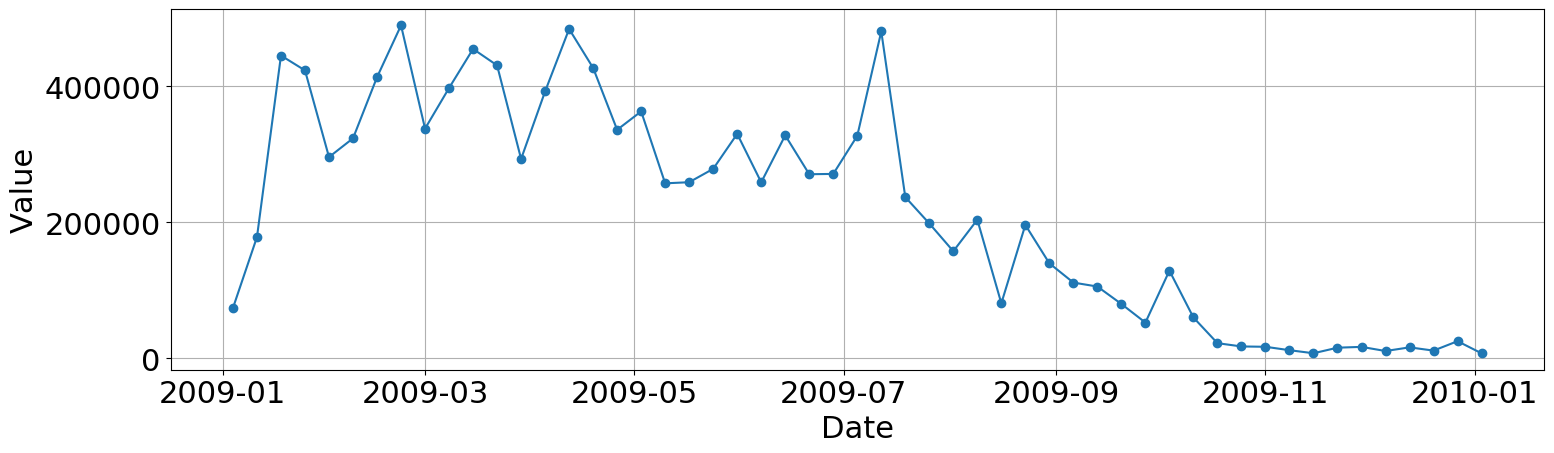

In [54]:
year.set_index('date_time', inplace=True)
results1 = year.groupby(pd.Grouper(freq='W')).size()
plot_df(results1, x=results1.index, y=results1, name="year_weekly_linear.png")

This time we group by month on the whole dataset

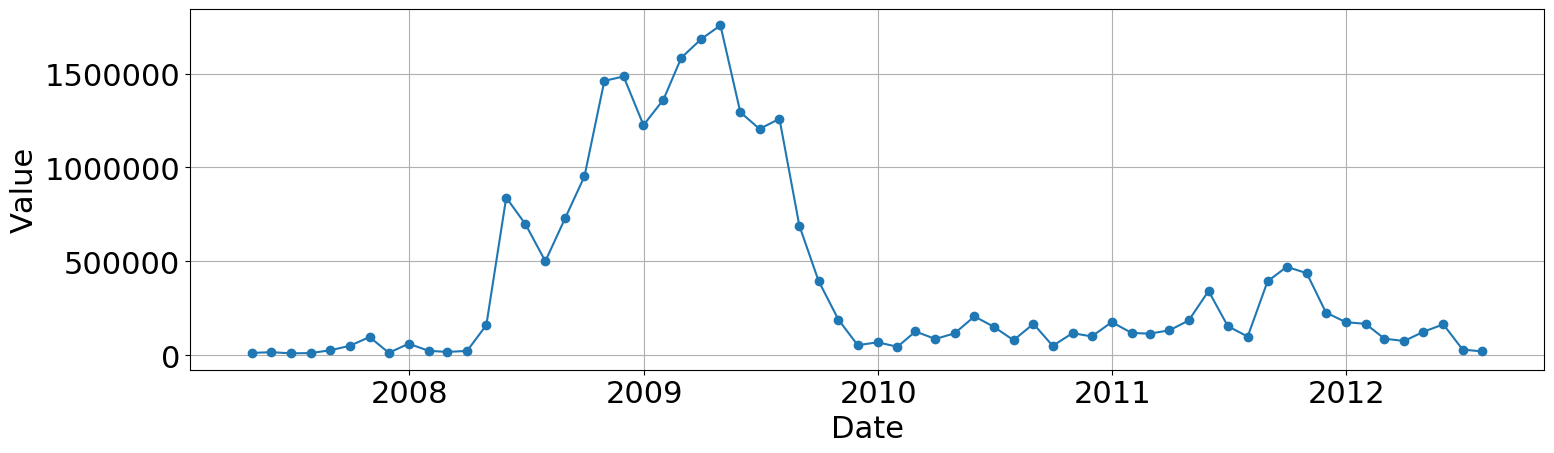

In [55]:
start_time = "2007-04-01 00:00:00"
end_time = "2012-08-31 23:59:00"
whole = df[(df["date_time"] > start_time) & (df["date_time"] < end_time)]

whole.set_index('date_time', inplace=True)
results2 = whole.groupby(pd.Grouper(freq='M')).size()
fig = plot_df(results2, x=results2.index, y=results2, \
             name="whole_monthly_linear.png")

Since it looks promising, we plot the points on a weekly basis in the 12 month period between 2008-06-01 and 2009-06-1

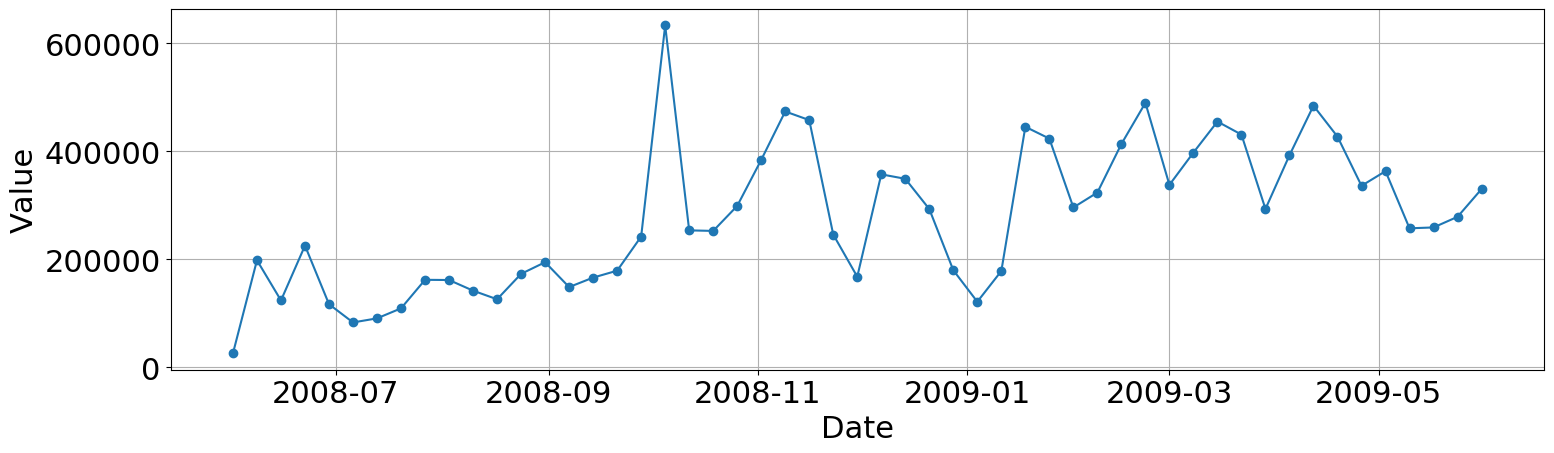

In [56]:
start_time = "2008-06-01 00:00:00"
end_time = "2009-06-1 00:00:00"
jun_jun = df[(df["date_time"] > start_time) & (df["date_time"] < end_time)]

jun_jun.set_index('date_time', inplace=True)
results3 = jun_jun.groupby(pd.Grouper(freq='W')).size()
fig = plot_df(results3, x=results3.index, y=results3, \
             name="jun2008-jun2009_weekly_linear.png")

Weekly for the whole dataset 

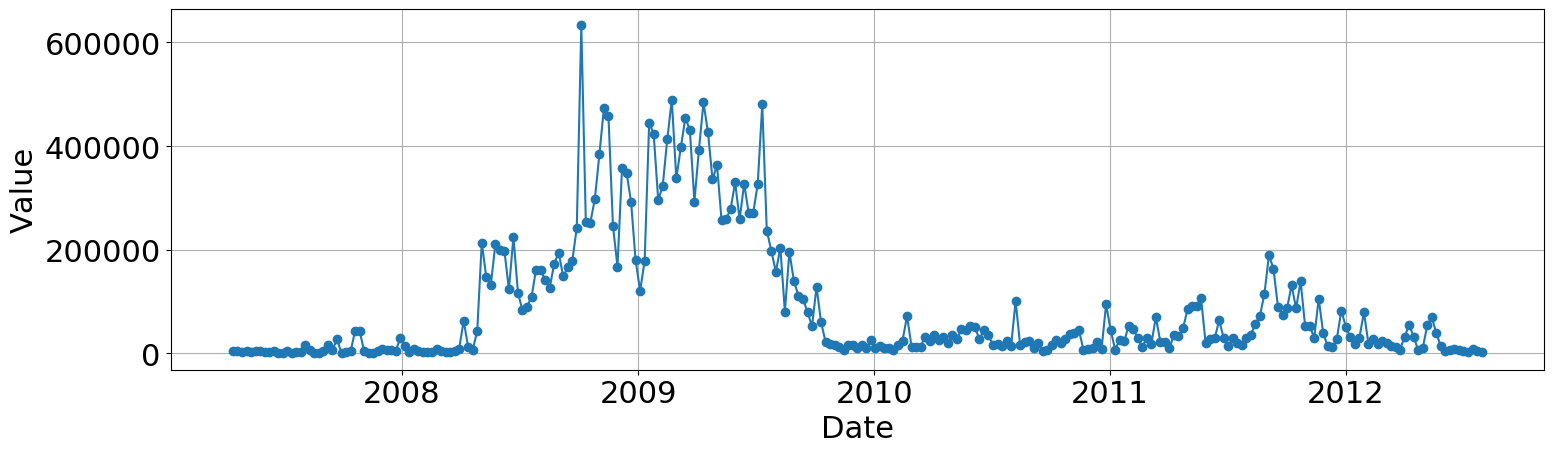

In [57]:
start_time = "2007-04-01 00:00:00"
end_time = "2012-08-31 23:59:00"
whole = df[(df["date_time"] > start_time) & (df["date_time"] < end_time)]

whole.set_index('date_time', inplace=True)
results2 = whole.groupby(pd.Grouper(freq='W')).size()
fig = plot_df(results2, x=results2.index, y=results2, \
             name="whole_weekly_linear.png")

## We try to determine how many distinct users were active in certain periods of time.
We start from June 2008 and then we analyze the whole 2008 summer from June to September.

In [39]:
#restricting to beijing area
df_t = df[(df['lat'].between(39, 41.5)) & (df['lon'].between(115, 117.5))]

#restricting to june 2008
start_time = "2008-06-01 00:00:00"
end_time = "2008-08-31 23:59:00"

june = df_t[(df_t.date_time > start_time) & (df_t.date_time < end_time)]

#now the whole summer
end_time = "2008-09-30 23:59:00"

summer = df_t[(df_t.date_time > start_time) & (df_t.date_time < end_time)]

Now let's see how many unique users we have for june and the whole summer.

In [40]:
print(str(june['uid'].nunique()) + " unique users for june 2008")
print(str(summer['uid'].nunique()) + " unique user for summer 2008")


KeyError: 'uid'

## Hetmaps with users

Now we restrict our coordinates to the beijing area by creating a view for the dataframe.<br>
Subsequently we copy that view to another dataframe (to avoid pandas SettingWithCopyWarning), then we delete the original df to spare some memory.

In [59]:
import datashader as ds
from datashader.utils import lnglat_to_meters as webm

#df_
df_t = df[(df['lat'].between(39, 41.5)) & (df['lon'].between(115, 117.5))]
df1 = df_t.copy(deep=True)

df1.loc[:, 'x'], df1.loc[:, 'y'] = webm(df_t.lon,df_t.lat)

del df, df_t

print(df1.head())
print(df1.info())

ModuleNotFoundError: No module named 'datashader'

Now we use Datashader to print a heatmap aggregating the gps points in the Beijing Area for the whole duration of Geolife's dataset

In [ ]:
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf

plot_width = int(2000)
plot_height = int(2000)

agg = ds.Canvas(plot_width, plot_height).points(df1, 'x', 'y')
img = tf.set_background(tf.shade(agg, cmap=fire),"black")
ds.utils.export_image(img=img,filename= geo_life_analysis_path + 'beijing_dshader', fmt=".png", background="black")

Using Holoview we now produce a zoomable map of the beijing area overlayed by the gps points.

In [ ]:
import holoviews as hv
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

map_tiles  = EsriImagery().opts(alpha=0.5, width=1400, height=1400, bgcolor='black')
points     = hv.Points(df1, ['x', 'y'])
tracks = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=1400, height=1400)


view = map_tiles * tracks
hv.save(view, geo_life_analysis_path + "beijing_holoview.png", fmt="auto")
view

Now we use folium to print some an heatmap of our data, once again focusing on the Beijing area.<br>
Since folium is much less optimized than datashader, we restrict our analysis to data recorded between June 1 2008 and July 1 2008, otherwise the heatmap crashes our browser.

In [ ]:
import folium 
from folium.plugins import HeatMap

#we center our map on beijing's approximate central coordinates
beijing = folium.Map(location=[39.916668, 116.383331], \
                    tiles="Stamen Terrain", zoom_start = 11)

#restricting our data a little bit (we offer a yearly view on the set already restricted for the beijing area.)
start_time = "2008-06-01 00:00:00"
end_time = "2008-06-30 23:59:00"
monthly = df1[(df1.date_time > start_time) & (df1.date_time < end_time)]

#we add all the gps points in the Beijing area to the map
HeatMap(monthly[['lat', 'lon']].values).add_to(beijing)

beijing.save(geo_life_analysis_path + "beijing_folium.html")
beijing

Now we use Seaborn to plot a couple more heatmaps about 2008 and 2009.<br>
We start with 2008.

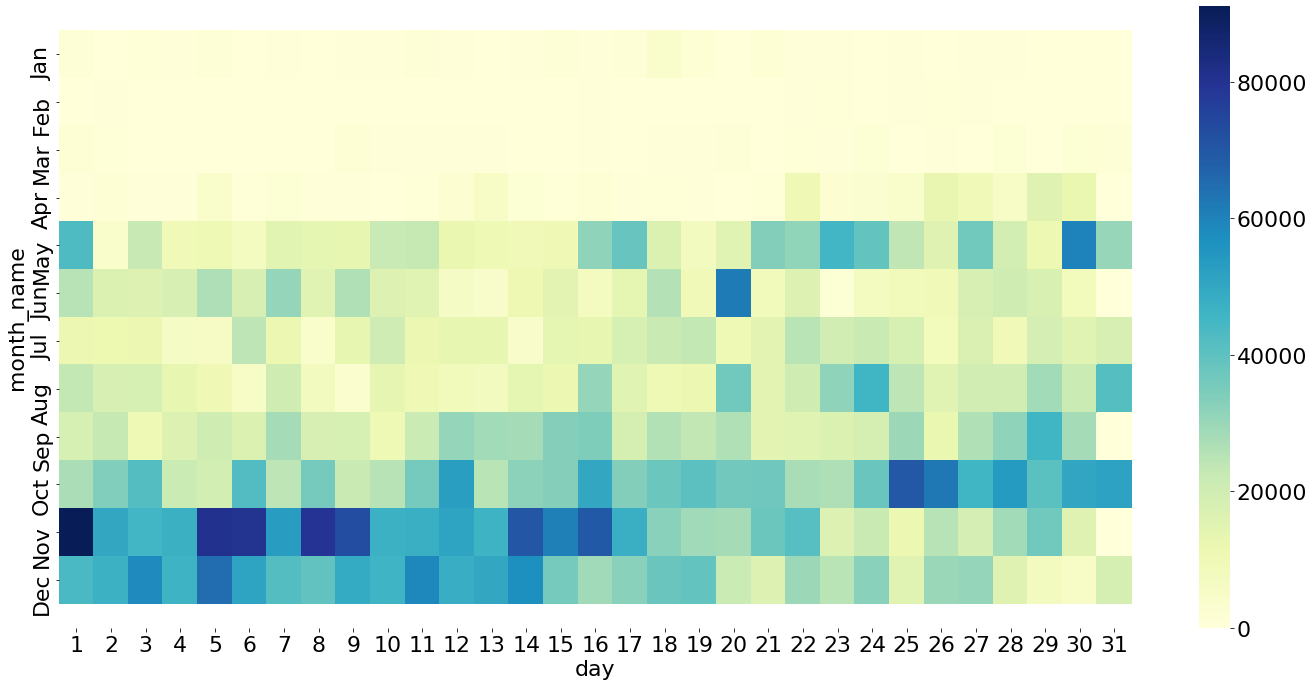

In [60]:
import seaborn as sns

df_t = df[(df['lat'].between(39, 41.5)) & (df['lon'].between(115, 117.5))]
df1 = df_t.copy(deep=True)

df1['month_name'] = df1['date_time'].dt.month;
df1['day'] = df1['date_time'].dt.day;

start_time = "2008-01-01 00:00:00"
end_time = "2008-12-31 23:59:00"
year2008 = df1[(df1.date_time > start_time) & (df1.date_time < end_time)]

series = year2008.groupby(["month_name", "day"]).size()
df2 = series.unstack(level=-1, fill_value=0)

fig, ax = plt.subplots(figsize=(20,10))

#ax.set_title("GPS points aggregated by day between Jan 1 2008 and Dec 31 2008")

img = sns.heatmap(df2, ax=ax, cmap="YlGnBu")
bottom, top = img.get_ylim()
img.set(yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

img.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig(geo_life_analysis_path + "/yrl_2008_heat.png")


Now we do the same thing for 2009

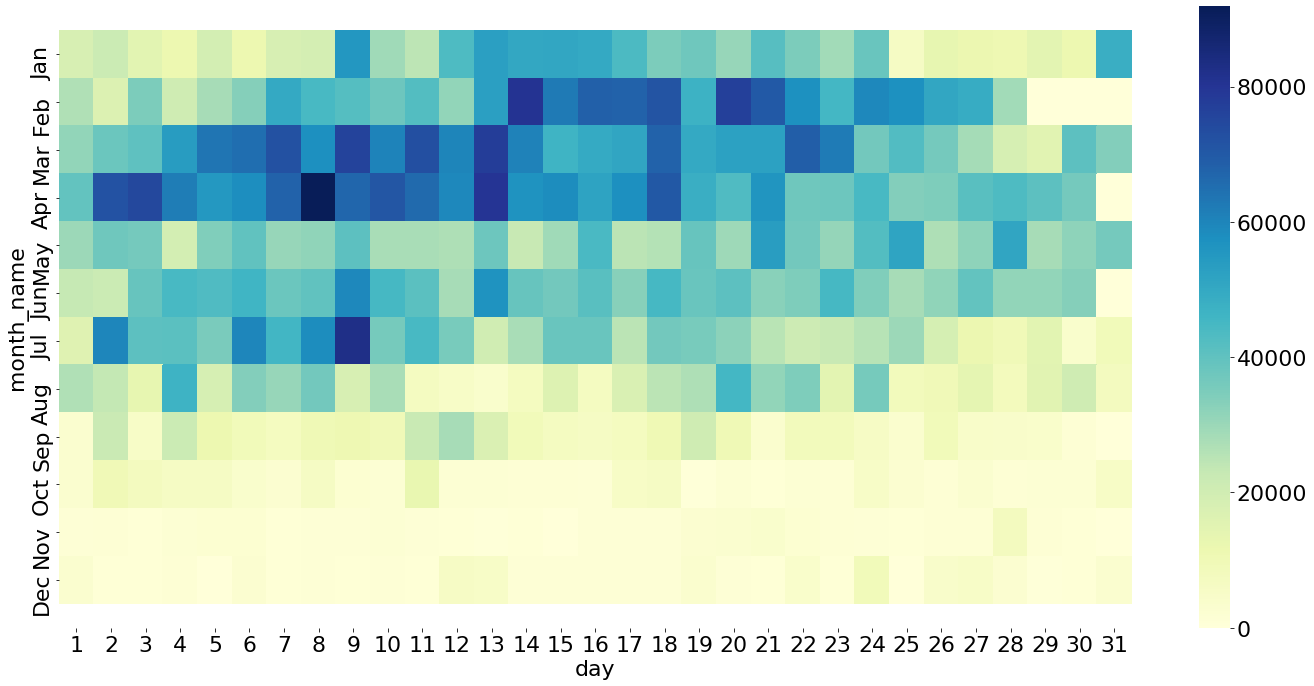

In [61]:
start_time = "2009-01-01 00:00:00"
end_time = "2009-12-31 23:59:00"
year2009 = df1[(df1.date_time > start_time) & (df1.date_time < end_time)]

series = year2009.groupby(["month_name", "day"]).size()
df3 = series.unstack(level=-1, fill_value=0)

fig, ax = plt.subplots(figsize=(20,10))

#ax.set_title("GPS points aggregated by day between Jan 1 2009 and Dec 31 2009")

img = sns.heatmap(df3, ax=ax, cmap="YlGnBu")
bottom, top = img.get_ylim()
img.set(yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

img.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig(geo_life_analysis_path + "/yrl_2009_heat.png")